<a href="https://colab.research.google.com/github/yghazi/fastai-notebooks/blob/main/ai_or_natural.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# It's a good idea to ensure you're running the latest version of any libraries you need.
# `!pip install -Uqq <libraries>` upgrades to the latest version of <libraries>
# NB: You can safely ignore any warnings or errors pip spits out about running as root or incompatibilities
!pip install -Uqq fastai duckduckgo_search

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 25.2 MB/s eta 0:00:00


This is a small experiment of trying to classify nature photo images as either real or ai generated. It's a combination of techniques taught in the first two lectures of the [fast.ai deep learning course](https://course.fast.ai).

The basic steps we'll take are:

1. Use DuckDuckGo to search for images of "real nature photos"
2. Use DuckDuckGo to search for images of "ai generated nature photos"
3. Fine-tune a pretrained neural network to recognise these two groups
4. Try running this model on a picture of a bird and see if it works.

## Step 1: Download images and create a dataset

In this step, we create a dataset for training and testing. We'll resize and normalize them. We'll make sure the downloads were valid and we'll split them randomly for training and testing.

In [2]:
from duckduckgo_search import DDGS
from fastcore.all import *

def search_images(term, max_images=30):
    print(f"Searching for '{term}'")
    with DDGS() as ddgs:
        # generator which yields dicts with:
        # {'title','image','thumbnail','url','height','width','source'}
        search_results = ddgs.images(keywords=term)
        # grap number of max_images urls
        image_urls = [next(search_results).get("image") for _ in range(max_images)]
        # convert to L (functionally extended list class from fastai)
        return L(image_urls)


Let's start by searching for a bird photo and seeing what kind of result we get. We'll start by getting URLs from a search:

In [3]:
urls = search_images("real nature photos", max_images=1)
print(urls[0])

Searching for 'real nature photos'
https://wallpaperaccess.com/full/5101344.jpg


...and then download a URL and take a look at it:

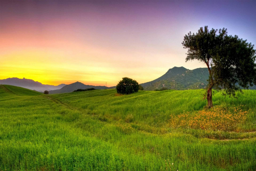

In [4]:
from fastdownload import download_url
dest = 'nature.jpg'
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

Now let's do the same with "plane photos":


Searching for 'ai generated nature photos'


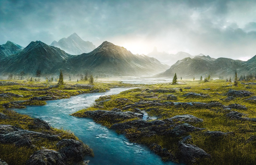

In [5]:
download_url(search_images('ai generated nature photos', max_images=1)[0], 'ai.jpg', show_progress=False)
Image.open('ai.jpg').to_thumb(256,256)

Our searches seem to be giving reasonable results, so let's grab a few examples of each of "real" and "ai generated" nature photos, and save each group of photos to a different folder (I'm also trying to grab a range of conditions here, like time of day or the kind of landscape):

In [6]:
searches = 'real','ai_generated'
path = Path('ai_or_not')
from time import sleep

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} nature photo'))
    sleep(10)  # Pause between searches to avoid over-loading server
    download_images(dest, urls=search_images(f'{o} mountains photo'))
    sleep(10)
    download_images(dest, urls=search_images(f'{o} waterfall photo'))
    sleep(10)
    download_images(dest, urls=search_images(f'{o} desert photo'))
    sleep(10)
    download_images(dest, urls=search_images(f'{o} nature day photo'))
    sleep(10)
    download_images(dest, urls=search_images(f'{o} nature night photo'))
    sleep(10)
    resize_images(path/o, max_size=400, dest=path/o)

Searching for 'real nature photo'
Searching for 'real mountains photo'
Searching for 'real waterfall photo'
Searching for 'real desert photo'
Searching for 'real nature day photo'
Searching for 'real nature night photo'
Searching for 'ai_generated nature photo'
Searching for 'ai_generated mountains photo'
Searching for 'ai_generated waterfall photo'
Searching for 'ai_generated desert photo'
Searching for 'ai_generated nature day photo'
Searching for 'ai_generated nature night photo'


This will store data in folders `ai_or_not/real` and `ai_or_not/ai_generated` and put the downloaded images in them, correspondingly.

## Step 2: Train our model

Some photos might not download correctly which could cause our model training to fail, so we'll remove them:

In [7]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

6

To train a model, we'll need `DataLoaders`, which is an object that contains a *training set* (the images used to create a model) and a *validation set* (the images used to check the accuracy of a model -- not used during training). In `fastai` we can create that easily using a `DataBlock`, and view sample images from it:

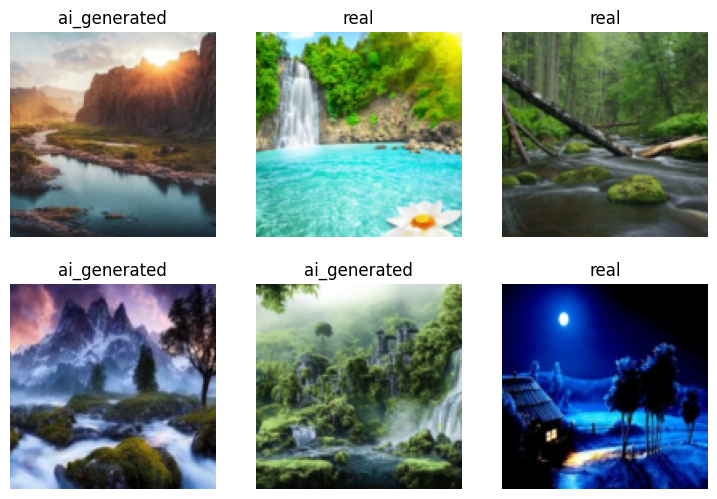

In [10]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[RandomResizedCrop(128, min_scale=0.3)]
).dataloaders(path, bs=32)

dls.show_batch(max_n=6)

Here's what each of the `DataBlock` parameters means:

    blocks=(ImageBlock, CategoryBlock),

The inputs to our model are images, and the outputs are categories (in this case, "bird" or "plane").

    get_items=get_image_files,

To find all the inputs to our model, run the `get_image_files` function (which returns a list of all image files in a path).

    splitter=RandomSplitter(valid_pct=0.2, seed=42),

Split the data into training and validation sets randomly, using 20% of the data for the validation set.

    get_y=parent_label,

The labels (`y` values) is the name of the `parent` of each file (i.e. the name of the folder they're in, which will be *bird* or *plane*).

    item_tfms=[Resize(192, method='squish')]

Before training, resize each image to 192x192 pixels by "squishing" it (as opposed to cropping it).

Now we're ready to train our model. The fastest widely used computer vision model is `resnet18`. You can train this in a few minutes, even on a CPU! (On a GPU, it generally takes under 10 seconds...)

`fastai` comes with a helpful `fine_tune()` method which automatically uses best practices for fine tuning a pre-trained model, so we'll use that.

In [20]:
??learn.fine_tune

In [11]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

epoch,train_loss,valid_loss,error_rate,time
0,1.035073,0.665008,0.261538,00:18


epoch,train_loss,valid_loss,error_rate,time
0,0.876905,0.617585,0.276923,00:24
1,0.682477,0.645404,0.215385,00:24
2,0.580309,0.578360,0.184615,00:24


Generally when I run this I see 100% accuracy on the validation set (although it might vary a bit from run to run).

"Fine-tuning" a model means that we're starting with a model someone else has trained using some other dataset (called the *pretrained model*), and adjusting the weights a little bit so that the model learns to recognise your particular dataset. In this case, the pretrained model was trained to recognise photos in *imagenet*, and widely-used computer vision dataset with images covering 1000 categories) For details on fine-tuning and why it's important, check out the [free fast.ai course](https://course.fast.ai/).

## Step 3: Use our model (and build your own!)

In [13]:
real_or_ai,_,probs = learn.predict(PILImage.create('ai.jpg'))
print(f"This is: {real_or_ai}.")
print(f"Probability it's a nature photo: {probs[1]:.4f}")

This is a: ai_generated.
Probability it's a nature photo: 0.0003


/usr/local/lib/python3.10/dist-packages/fastai/torch_core.py:263: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  return getattr(torch, 'has_mps', False)


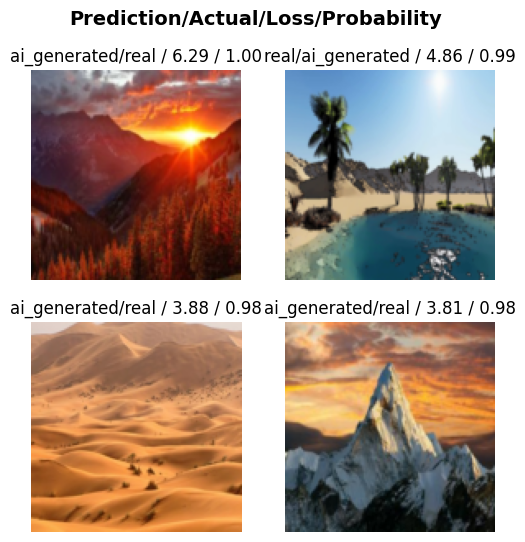

In [17]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_top_losses(k=4)

In [23]:
interp.print_classification_report()

/usr/local/lib/python3.10/dist-packages/fastai/torch_core.py:263: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  return getattr(torch, 'has_mps', False)


              precision    recall  f1-score   support

ai_generated       0.78      0.91      0.84        34
        real       0.88      0.71      0.79        31

    accuracy                           0.82        65
   macro avg       0.83      0.81      0.81        65
weighted avg       0.83      0.82      0.81        65



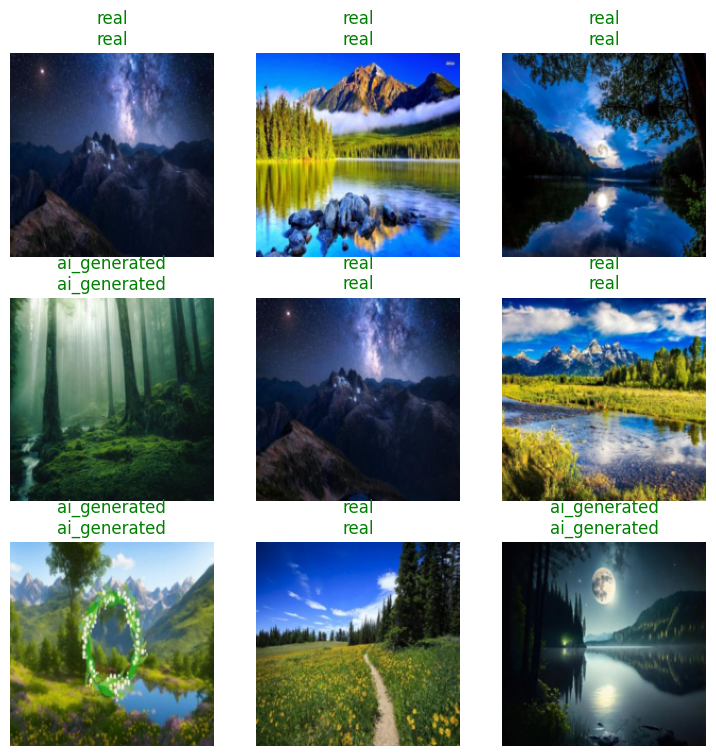

In [ ]:
learn.show_results()

Good job, resnet18. :)

So, as you see, in the space of a few years, creating computer vision classification models has gone from "so hard it's a joke" to "trivially easy and free"!

It's not just in computer vision. Thanks to deep learning, computers can now do many things which seemed impossible just a few years ago, including [creating amazing artworks](https://openai.com/dall-e-2/), and [explaining jokes](https://www.datanami.com/2022/04/22/googles-massive-new-language-model-can-explain-jokes/). It's moving so fast that even experts in the field have trouble predicting how it's going to impact society in the coming years.

One thing is clear -- it's important that we all do our best to understand this technology, because otherwise we'll get left behind!